# Predicting Heart Disease

The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1) estimates that approximately 17.9 million individuals lose their lives due to cardiovascular diseases (CVDs) annually.

There are various risk factors that might contribute to the development of CVDs in individuals, including an unhealthy diet, insufficient physical activity, and mental health issues. Detecting these risk factors early can significantly reduce the number of premature deaths.

We are engaged with an R&D firm that focuses on providing healthcare solutions. The company has gathered anonymized data from numerous hospitals concerning multiple patients. The [dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) includes pertinent patient information and medical data, including their history of heart disease.

Our responsibility involves utilizing this dataset to precisely forecast the probability of a new patient developing heart disease. The dataset comprises the following attributes:

1.```Age```: age of the patient (years).

2.```Sex```: sex of the patient (M: Male, F: Female).

3.```ChestPainType```: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic).

4.```RestingBP```: resting blood pressure (mm Hg).

5.```Cholesterol```: serum cholesterol (mm/dl).

6.```FastingBS```: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise).

7.```RestingECG```: resting electrocardiogram results (Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria).

8.```MaxHR```: maximum heart rate achieved (Numeric value between 60 and 202).

9.```ExerciseAngina```: exercise-induced angina (Y: Yes, N: No).

10.```Oldpeak```: oldpeak = ST (Numeric value measured in depression).

11.```ST_Slope```: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping).

12.```HeartDisease```: output class (1: heart disease, 0: Normal).


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Ensure plots are displayed within the notebook
%matplotlib inline

In [2]:
# Read the datset
heart_disease = pd.read_csv('heart_disease_prediction.csv')

#Display the first five rows
heart_disease.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# EDA: Descriptive Statistics

We've examined the initial five rows of the data, which seem to include a mix of both categorical and numerical attributes. Now, let's proceed to inspect the data type of each column.

In [3]:
# Explore the types of features on each column
print(heart_disease.dtypes)

# Count of types
heart_disease.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
dtype: int64

We can observe that 7 columns are of numerical type: ```Age```, ```RestingBP```, ```Cholesterol```, ```FastingBS```,```MaxHR```, ```Oldpeak```,and ```HeartDisease```; while 5 columns are of categorical type: ```Sex```, ```ChestPainType```, ```RestingECG```, ```ExerciseAngina```, and ```ST_Slope```. However, two of the numerical features, ```FastingBS``` and ```HeartDisease``` are categorical as well since they only contain binary values. We will focus on the numerical variables first.

In [4]:
# Generate descriptive statistics for the dataset.
round(heart_disease.describe(),2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


After examining the table above, we've gathered these insights:

- Average Patient Age: The patients' average age is around 53.5 years.

- No Missing Values: Good news—there seem to be no missing values. The count for each column matches the total number of observations (918) in the dataset. We'll dig deeper to confirm this.

- ```RestingBP``` and ```Cholesterol Values```: We noticed both ```RestingBP``` and ```Cholesterol```
columns have a minimum value of 0. However, ```RestingBP``` represents resting blood pressure, and it's unlikely to be 0. Similarly, ```Cholesterol``` involves serum cholesterol values, which are a mix of HDL and LDL cholesterol levels, along with a fraction of triglyceride levels, as per the American Heart Association. So a value of 0 for Cholesterol is improbable too. We'll handle these anomalies during the data cleaning phase.

Now we'll confirm if there are any missing values in the dataset.

In [5]:
# Count the number of missing values in each column of 
heart_disease.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in this dataset.

# EDA: Visualizations: Bar Charts for Categorical Columns

In this section, we'll visualize categorical columns (```FastingBS``` and ```HeartDisease``` are included), using bar charts. The purpose is to gain insights into the distribution of categories within these columns.

Let's proceed with the code to achieve this visualization.

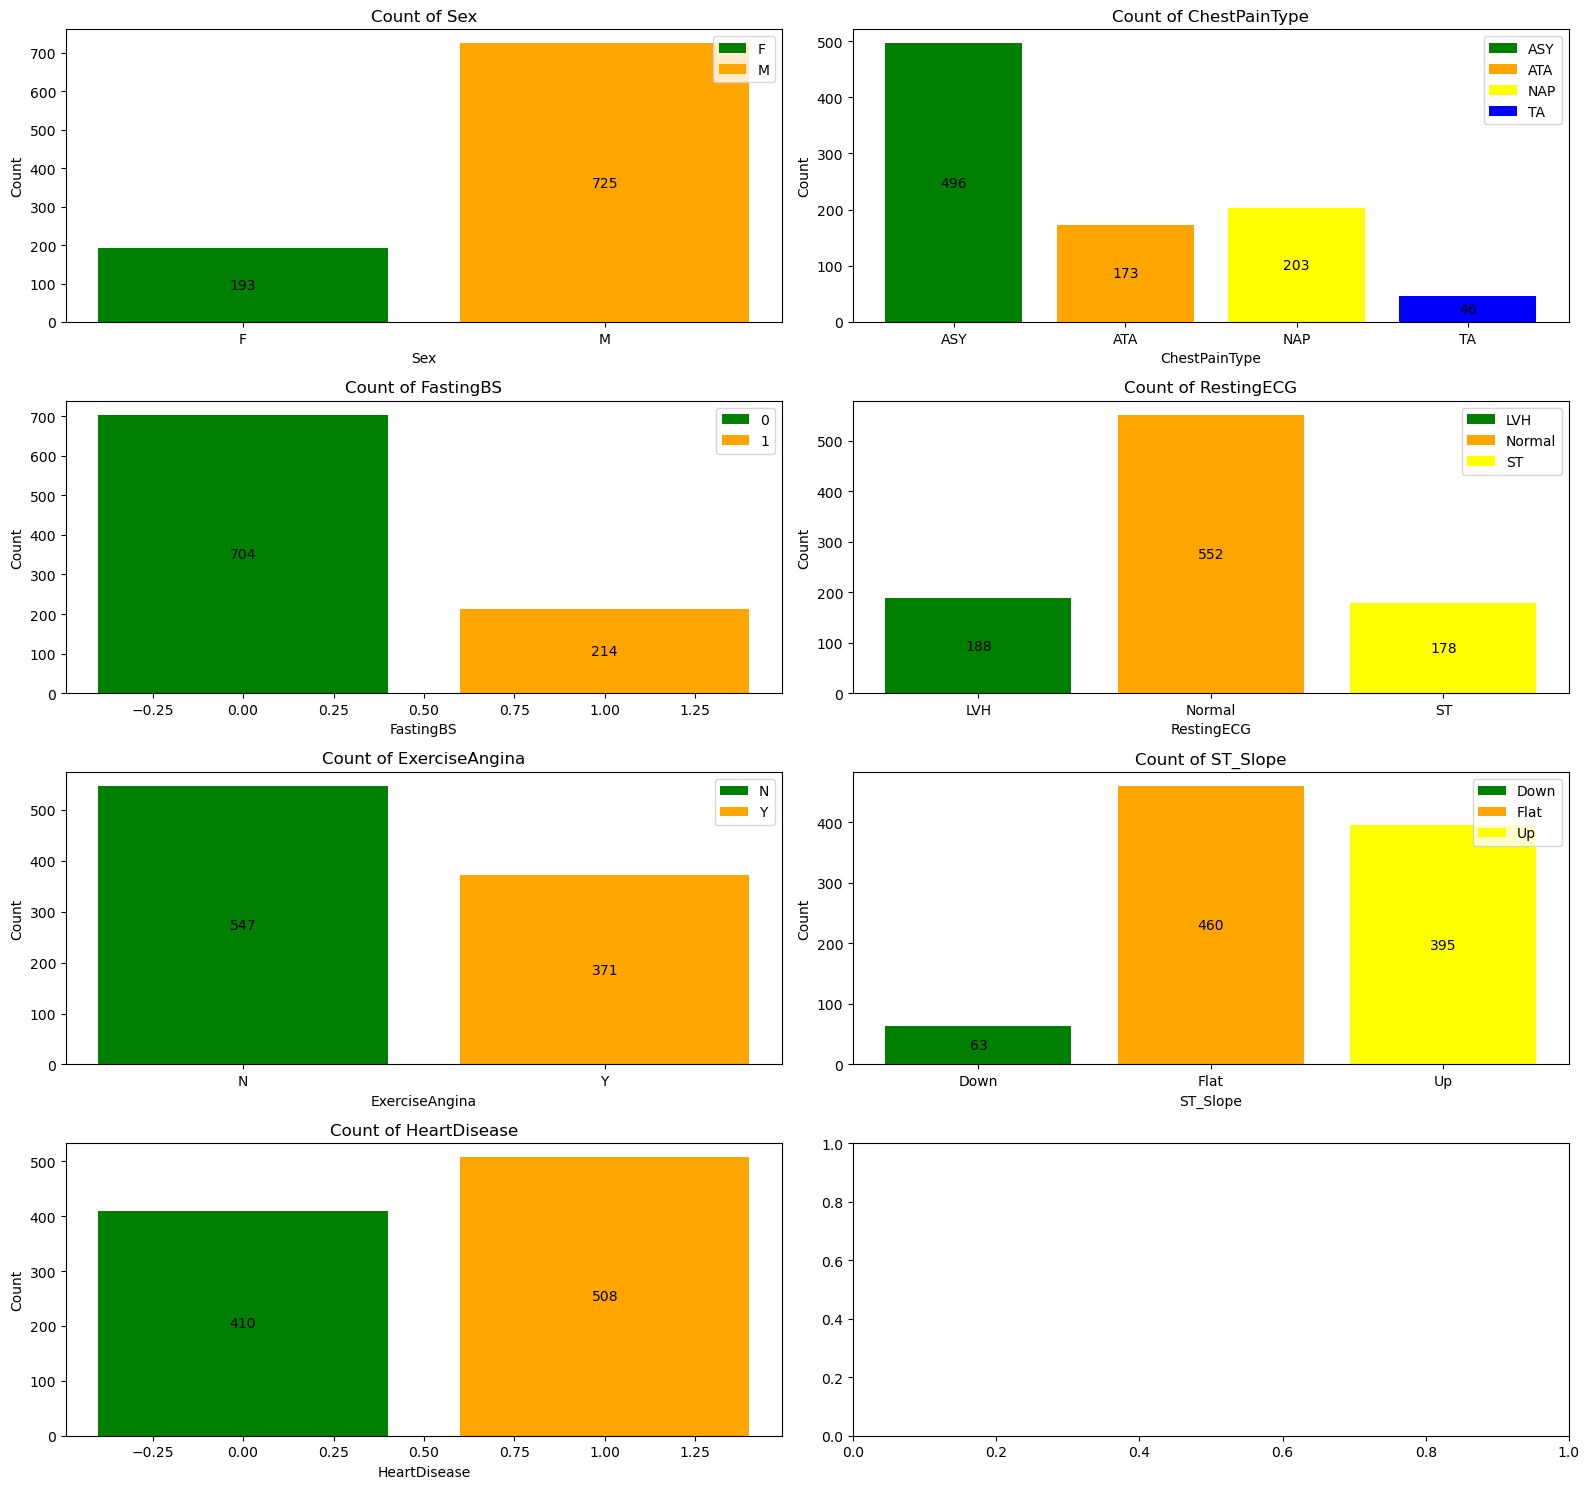

In [6]:
# List of columns to visualize
columns = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

# Create a figure with subplots
fig, axes = plt.subplots(4, 2, figsize=(16, 15))
plt.subplots_adjust(hspace=0.5)

# Define a color palette for visualization
color_palette = ['green', 'orange', 'yellow', 'blue']

# Iterate through columns for visualization
for i, col in enumerate(columns):
    row = i // 2
    col_data = heart_disease[col]  # Access the column data
    ax = axes[row, i % 2]
    
    categories, counts = np.unique(col_data, return_counts=True)
    bars = ax.bar(categories, counts, color=color_palette)
    
    ax.set_title(f'Count of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    
    # Add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
    
    # Customize legend for categorical columns
    if col != 'HeartDisease':
        ax.legend(bars, categories, loc='upper right')
    
# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Here are the key takeaways from the charts:

- The dataset is heavily skewed towards male patients, with 725 males and 193 females.

- Among the patients, 508 were diagnosed with heart disease, while 410 were not.

- A substantial count of 496 patients exhibit ASY type of chest pain.

- Additionally, 547 patients do not experience exercise-induced angina.

We will create a bar chart grouped by ```HeartDisease``` to have a more comprehensive understanding of the data distribution.

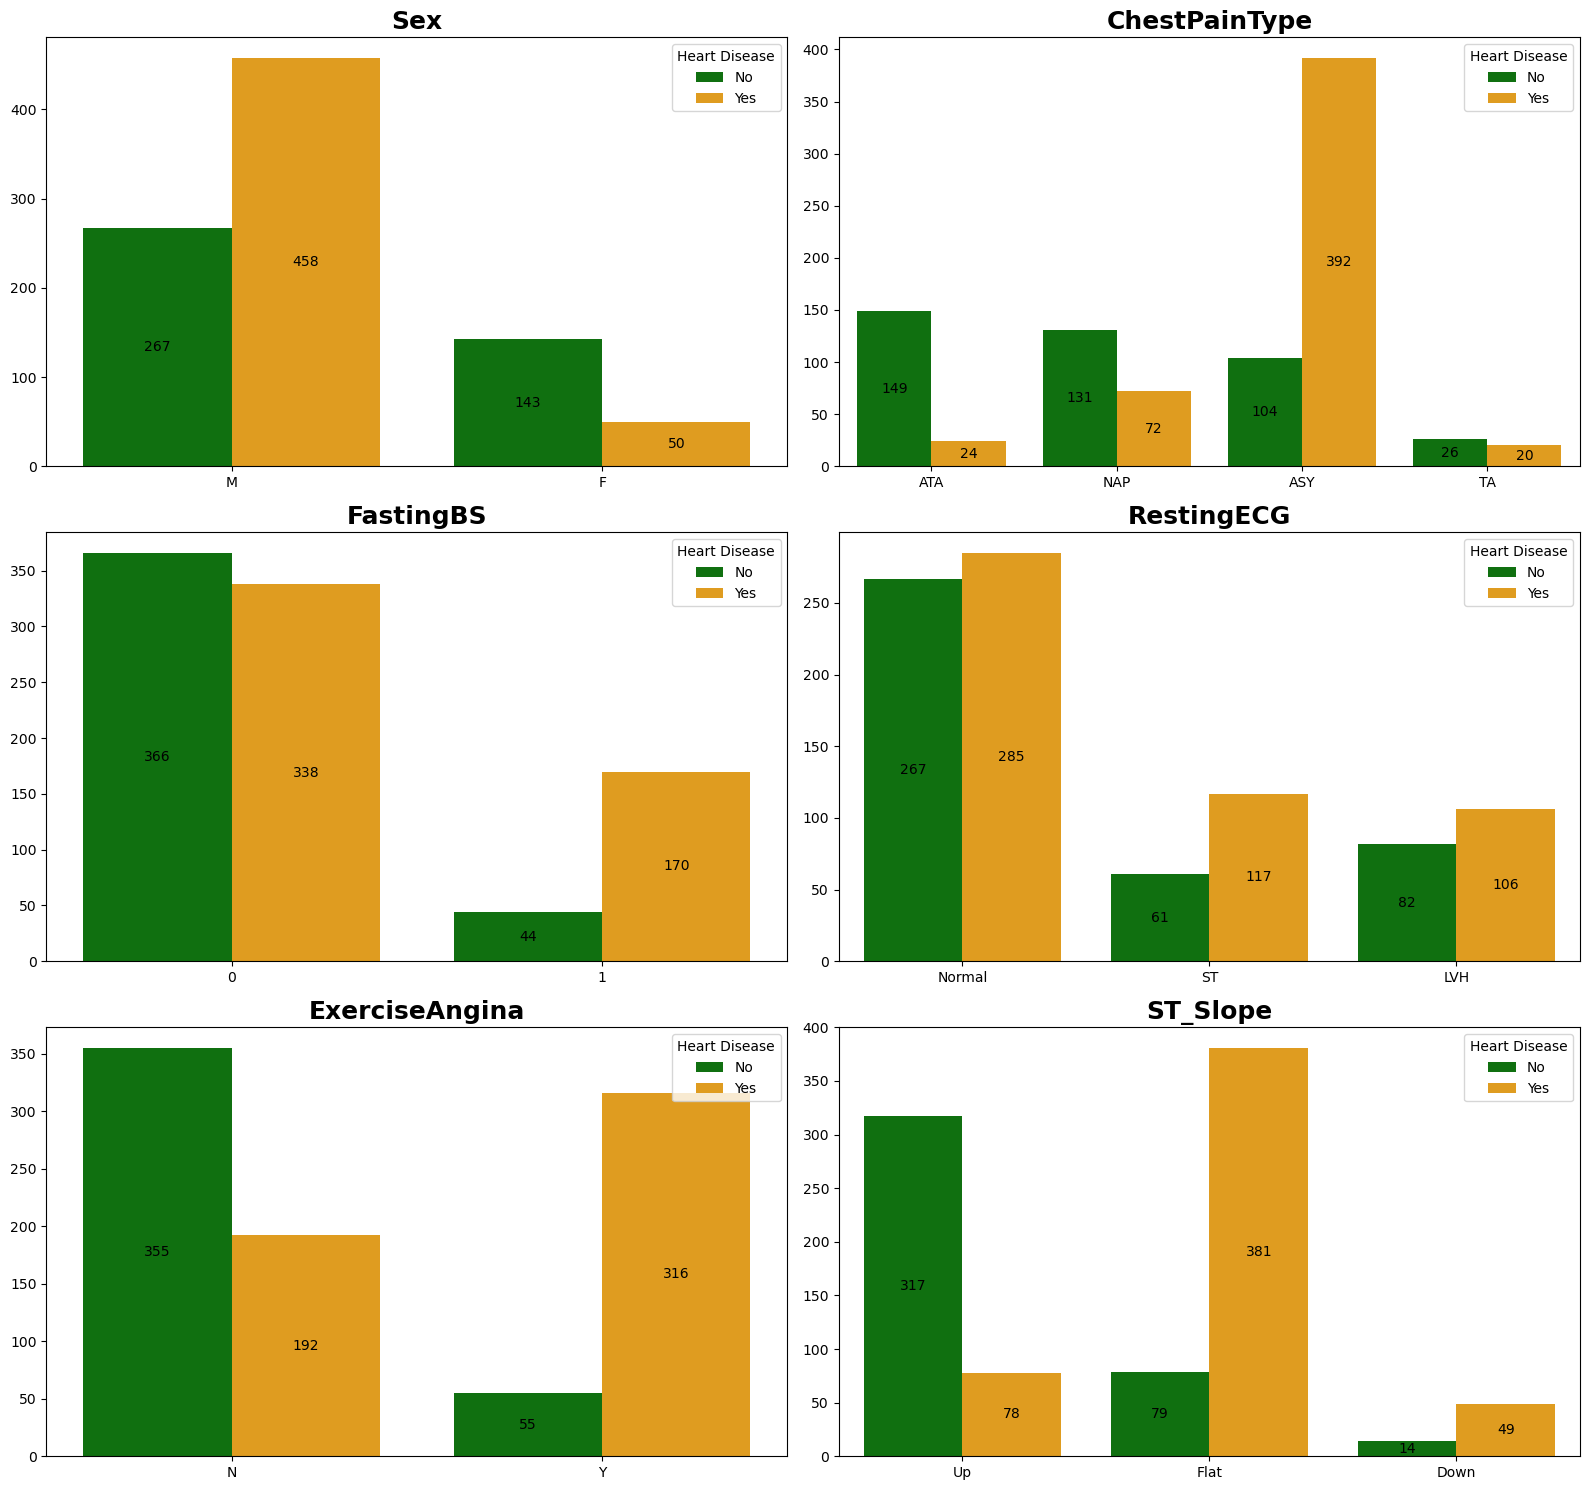

In [7]:
# Create subplots arrangement
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
plt.subplots_adjust(hspace=0.5)

# Iterate through columns for visualization
for idx, col in enumerate(columns[:-1]):
    # Calculate subplot row and column indices
    row = idx // 2
    ax = axes[row, idx % 2]
    
    # Create a countplot grouped by HeartDisease
    sns.countplot(data=heart_disease, x=col, hue="HeartDisease", ax=ax, palette=color_palette)
    
    # Set plot title and label styles
    ax.set_title(col, weight='bold', size=18)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
    
    # Customize legend and its location
    ax.legend(labels=['No', 'Yes'], title='Heart Disease', fancybox=True, loc='upper right', fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

Some key observations derived from the bar chart:

- Among patients diagnosed with heart disease, 458 are male, and 50 are female. Additionally, 267 males and 143 females remain unaffected by heart disease.

- Within the 508 heart disease patients, 392 experience the ASY type of chest pain.

- The majority of heart disease patients (338 out of 508) exhibit fasting blood sugar levels < 120 mg/dl.

- A significant majority of heart disease patients (285 out of 508) show normal RestingECG readings.

- Patients experiencing exercise-induced angina have a higher likelihood of being diagnosed with heart disease (316 out of 351), whereas those without this condition are less prone to heart disease diagnosis (192 out of 547).

- 381 heart disease patients have a flat ST_Slope.

Next, we will focus on two questions regarding patients diagnosed with heart disease:

1. What percentage of patients with heart disease are male and over 50 years old?
2. What is the median age of patients diagnosed with heart disease?"

In [8]:
# Select heart disease cases
heart_disease_cases = heart_disease[heart_disease['HeartDisease'] == 1]

# Count male patients over 50 years old
over_50_male_count = len(heart_disease_cases[(heart_disease_cases['Sex'] == 'M') & (heart_disease_cases['Age'] > 50)])

# Calculate percentage
percentage_over_50 = (over_50_male_count / len(heart_disease_cases)) * 100

# Print result
print("{:.2f}%".format(round(percentage_over_50, 2)), "of patients with heart disease are male and over 50 years old.")

67.72% of patients with heart disease are male and over 50 years old.


In [9]:
# Calculate the median age of patients with heart disease
median_age_heart_disease = heart_disease[heart_disease['HeartDisease'] == 1]['Age'].median()

# Print the result
print("The median age of patients diagnosed with heart disease is:", median_age_heart_disease)

The median age of patients diagnosed with heart disease is: 57.0


# Data Cleaning: Managing Zero Values

We have previously determined that there are no missing values but some occurrences of 0 values in the ```RestingBP``` and ```HeartDisease``` columns. Let's proceed to ascertain the count of rows for each of these cases.

In [10]:
# Count the number of rows that have 0 value for RestingBP.
heart_disease1=heart_disease.copy()

RestingBP_Zero = heart_disease1[heart_disease1['RestingBP'] == 0]
print(len(RestingBP_Zero),"row of 0 value for RestingBP")

# Count the number of rows that have 0 value for Cholesterol.
Cholesterol_Zero = heart_disease1[heart_disease1['Cholesterol'] == 0]
print(len(Cholesterol_Zero),"rows of 0 value for Cholesterol")

1 row of 0 value for RestingBP
172 rows of 0 value for Cholesterol


There is 1 row with a 0 value in the ```RestingBP``` column. We will exclude this row from our analysis as it is not expected to significantly impact the results.

In the case of the ```Cholesterol``` column, there are 172 rows with 0 values, which is almost 20% of the total dataset. We have chosen not to remove these rows, as doing so could adversely affect our overall analysis and results. Instead, we will impute these 0 values with the median value of the ```Cholesterol``` column.

In [11]:
# Removing 0 value of RestingBP

heart_disease1 = heart_disease1.drop(RestingBP_Zero.index)

print("Remaining rows of dataset:",heart_disease1.shape[0])

Remaining rows of dataset: 917


In [12]:
# Display statistical information of Cholesterol column before replacing 0 values with median
print("Statistical information of Cholesterol column: before replacing 0 value with median:")
print(heart_disease1['Cholesterol'].describe())
print('\n')

# Calculate median of non-zero Cholesterol values
non_zero_cholesterol = heart_disease1[heart_disease1['Cholesterol'] != 0]
mean_non_zero_cholesterol = non_zero_cholesterol['Cholesterol'].median()

# Replace 0 values in Cholesterol column with the calculated median
heart_disease1['Cholesterol'] = heart_disease1['Cholesterol'].replace(0, mean_non_zero_cholesterol)

# Display statistical information of Cholesterol column after replacing 0 values with median
print("Statistical information of Cholesterol column: after replacing 0 value with median:")
print(heart_disease1['Cholesterol'].describe())

Statistical information of Cholesterol column: before replacing 0 value with median:
count    917.000000
mean     199.016358
std      109.246330
min        0.000000
25%      174.000000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64


Statistical information of Cholesterol column: after replacing 0 value with median:
count    917.000000
mean     243.211559
std       53.430044
min       85.000000
25%      214.000000
50%      237.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64


# Data Cleaning: Removing Outliers

We will focus on enhancing performance accuracy by refining our dataset's numerical value columns. We'll remove data points that are more than three standard deviations away. This helps us handle outliers—values that can skew statistics and harm the reliability of our analysis.

In [13]:
# List of numerical columns
numerical_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Create a copy of the 'heart_disease' DataFrame
clean_heart_disease = heart_disease1.copy()

# Calculate the condition for values within 3 standard deviations from the mean
deviation_condition = np.abs(clean_heart_disease[numerical_columns] - clean_heart_disease[numerical_columns].mean()) / clean_heart_disease[numerical_columns].std() <= 3

# Apply the condition to filter the DataFrame
clean_heart_disease = clean_heart_disease[deviation_condition.all(axis=1)]

# Display summary statistics of the cleaned DataFrame
clean_heart_disease.describe()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,53.505062,131.984252,239.748031,0.231721,136.919010,0.859168,0.546682
std,9.472710,17.169130,45.570453,0.422169,25.341456,1.004779,0.498096
min,28.000000,80.000000,85.000000,0.000000,63.000000,-2.000000,0.000000
25%,47.000000,120.000000,213.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.000000,264.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,185.000000,394.000000,1.000000,202.000000,4.000000,1.000000


In [14]:
# Identify the weight of rows that were remaining

percent_remaining = clean_heart_disease.shape[0]/heart_disease.shape[0] *100

print(f"{percent_remaining:.2f}% of dataset were within standard deviation 3.")

96.84% of dataset were within standard deviation 3.


Let's visualize the distribution of Cholesterol values before and after data cleaning.

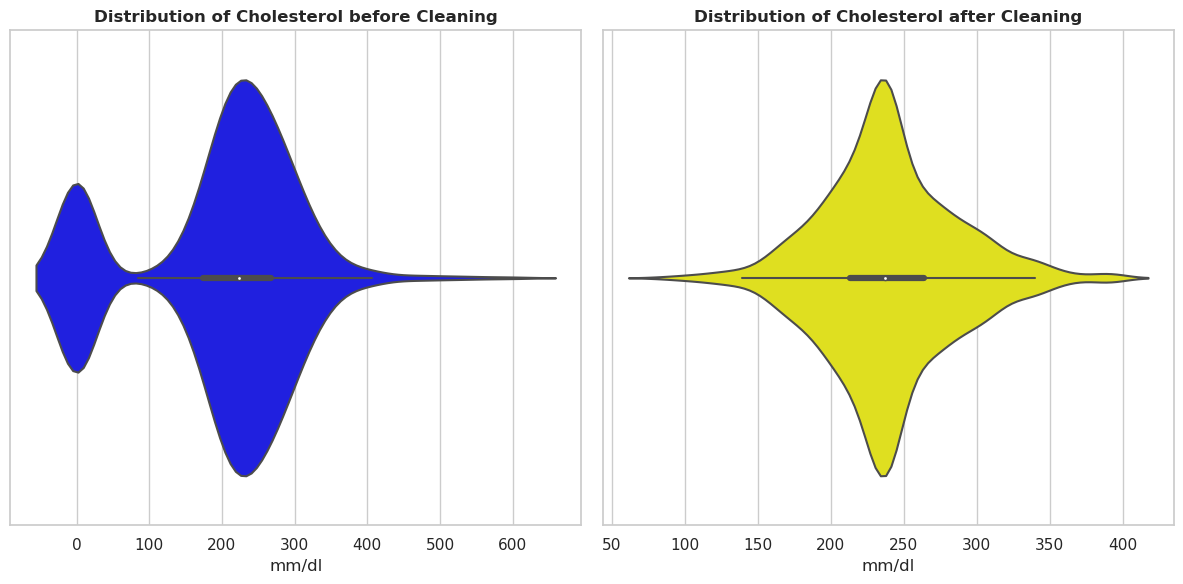

In [15]:
# Set the style
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Violin plot for Cholesterol before cleaning
sns.violinplot(data=heart_disease, x="Cholesterol", color='blue', ax=axes[0])
axes[0].set_title('Distribution of Cholesterol before Cleaning', weight='bold')
axes[0].set_xlabel('mm/dl')

# Violin plot for Cholesterol after cleaning
sns.violinplot(data=clean_heart_disease, x="Cholesterol", color='yellow', ax=axes[1])
axes[1].set_title('Distribution of Cholesterol after Cleaning', weight='bold')
axes[1].set_xlabel('mm/dl')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The left plot shows the initial distribution, and the right plot displays the distribution after removing outliers.

After cleaning the dataset for the ```RestingBP``` and ```Cholesterol``` columns and eliminating outliers, we still have over 96% of the dataset intact. A 4% reduction is acceptable for our prediction needs.

# Feature Selection

The data is clean and ready. Next, we'll choose features for our model. But before that, let's convert the categorical features into dummy variables.

In [16]:
# Convert categorical features into dummy variables
clean_heart_disease = pd.get_dummies(data=clean_heart_disease, drop_first=True)

clean_heart_disease.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


<AxesSubplot:>

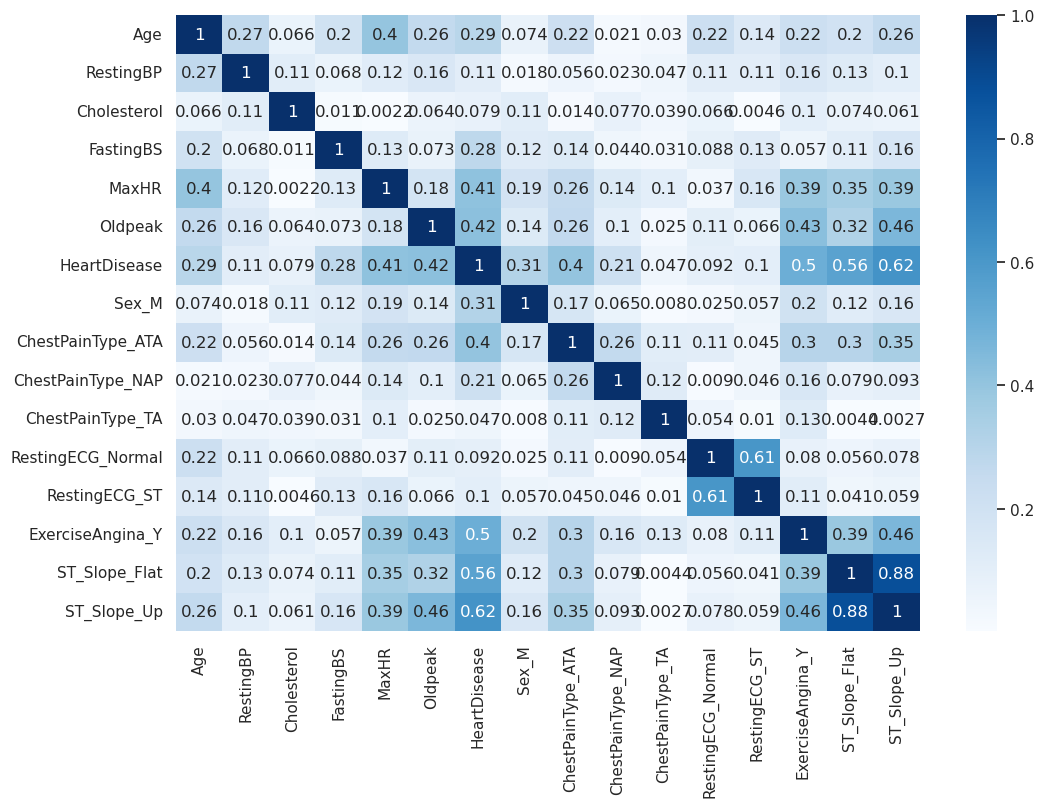

In [17]:
# Calculate absolute correlations
correlations = abs(clean_heart_disease.corr())

# Set up the figure size for the heatmap
plt.figure(figsize=(12, 8))

# Create a heatmap of correlations
sns.heatmap(correlations, annot=True, cmap="Blues")

The correlation heatmap shows the level of correlation is determined by the amount of lightness or darkness in the color's hue. Positive corrrelation indicates positive relationsship, whereas negative corraltion indicates negative relationship. The lighter the color is, the weaker correlation is between two variables. 

Now we want to get the features that have at least a 0.3 correlation coefficient with ```HeartDisease```.

In [18]:
# Getting features that have greater than 0.3 correlation with "HeartDisease"
top_features = correlations[(correlations["HeartDisease"] > 0.3) & (correlations["HeartDisease"] < 1)].index

top_features

Index(['MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

We will select ```MaxHR```, ```Oldpeak```, ```Sex_M```, ```ChestPainType_ATA```, ```ExerciseAngina_Y```, ```ST_Slope_Flat```, and ```ST_Slope_Up``` for our model. These features exhibit moderate to high correlation with HeartDisease.

# Building a Classifier with One Feature

The test size is typically set between 15% to 20% of the dataset. In our case, we will use a 20% test size for our model. We'll set the random state to 100 for reproducibility, and initially choose the number of neighbors as k = 5.  We will split the data into training and validation sets.

In [19]:
# Separate features and target variable
X = clean_heart_disease.drop(["HeartDisease"], axis=1)
y = clean_heart_disease["HeartDisease"]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

# Iterate through top features and train k-NN classifiers
for feature in top_features:
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} with k = 5 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on MaxHR with k = 5 has an accuracy of 57.87%
The k-NN classifier trained on Oldpeak with k = 5 has an accuracy of 50.56%
The k-NN classifier trained on Sex_M with k = 5 has an accuracy of 62.92%
The k-NN classifier trained on ChestPainType_ATA with k = 5 has an accuracy of 66.29%
The k-NN classifier trained on ExerciseAngina_Y with k = 5 has an accuracy of 71.91%
The k-NN classifier trained on ST_Slope_Flat with k = 5 has an accuracy of 77.53%
The k-NN classifier trained on ST_Slope_Up with k = 5 has an accuracy of 82.02%


Among those 7 features, the best performance is achieved by ```ST_Slope_Up``` with an accuracy of 82.02%, followed by ```ST_Slope_Flat``` with an accuracy of 77.53%.

# Building a Classifier with Multiple Features

We are now preparing to train the model using all the selected features. Before proceeding, we need to normalize this dataset. Normalization is a data preprocessing technique used to scale feature values within a dataset to a range of [0, 1]. This prevents any single feature from dominating others in the model, thereby enhancing overall model performance and accuracy.

In [20]:
# Create an instance of MinMaxScaler to normalize the dataset
scaler = MinMaxScaler()

# Normalize selected features for training and validation sets
X_train_scaled = scaler.fit_transform(X_train[top_features])
X_val_scaled = scaler.transform(X_val[top_features])

# Dictionary to store accuracy values
accuracies = {}

# Iterate over different k values
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    val_accuracy = knn.score(X_val_scaled, y_val)
    accuracies[i] = round(val_accuracy * 100, 2)

# Display accuracy values
print(accuracies)

{1: 76.97, 2: 75.28, 3: 82.02, 4: 78.09, 5: 82.02, 6: 79.78, 7: 81.46, 8: 79.21, 9: 81.46, 10: 80.34}


We've experimented with several values for k, and we've observed that k=3 and k=5 resulted in relatively good accuracy scores.

# Hyperparameter Optimization
We now have a reasonably well-performing model. However, we can further enhance its performance by experimenting with different parameters and hyperparameters. To achieve this, we will utilize ```GridSearchCV``` to search for the optimal combination of these values. The hyperparameters we will focus on include:

- ```n_neighbors```,
- ```metric```,
- ```weights```,
- ```algorithm```.

Let's start by preparing the data.

In [21]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X[top_features], y, test_size=0.2, random_state=100)

# Create an instance of MinMaxScaler to normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define grid parameters for hyperparameter tuning
grid_params = {
    "n_neighbors": range(1, 20),
    "metric": ["minkowski", "manhattan"],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}

# Create a k-NN classifier instance
knn = KNeighborsClassifier()

# Initialize GridSearchCV for hyperparameter tuning
knn_grid = GridSearchCV(knn, grid_params, scoring='accuracy')

# Fit the GridSearchCV to find the best parameters
knn_grid.fit(X_train_scaled, y_train)

# Display best score and best parameters
best_score = round(knn_grid.best_score_ * 100,2)
best_params = knn_grid.best_params_
print(best_score, best_params)

85.37 {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'uniform'}


The GridSearchCV results indicate that the best KNN classifier achieved an accuracy of 85.37%. It achieved peak performance with these settings:

- algorithm: the algorithm used to compute the nearest neighbors. In this case, 'ball_tree' indicates that the ball tree algorithm was selected for nearest neighbor search.

- metric: The distance metric used to compute the distances between instances. In this case, The Manhattan distance metric was used to measure distances between data points.

- n_neighbors: The number of neighbors to consider when making predictions. The value 19 was found to be the optimal number of neighbors for the KNN algorithm.

* weights: The weight function used in prediction. Uniform weighting was used for neighbors, meaning that all neighbors contributed equally to the prediction.

These outcomes mark the ultimate KNN classifier configuration, extracted through a thorough grid search using provided parameters and a selected scoring metric.

# Model Evaluation on Test Set

We will evaluate our model on our test set now. We need to first normalize our test set similar to how we scaled our training set.

In [22]:
# Normalize the test set using the same scaler
X_test_scaled = scaler.transform(X_test[top_features])

# Make predictions using the best estimator from GridSearchCV
predictions = knn_grid.best_estimator_.predict(X_test_scaled)

# Calculate model accuracy on the test set
accuracy = accuracy_score(y_test, predictions)

# Display the model accuracy on the test set
print(f"Model Accuracy on test set: {accuracy * 100:.2f}%")

Model Accuracy on test set: 84.27%


As a result of our analysis, we achieved a test set accuracy of 84.27%. This suggests that our model is capable of accurately predicting the presence or absence of heart disease in approximately 84.27 out of every 100 cases.

However, it's important to highlight that the test set accuracy of 84.27% is slightly below the training set accuracy of 85.37% that was previously mentioned. This difference could be because of the random nature of the training process and the fact that the test set contains different types of cases.

# Conclusion

In this project, we embarked on the task of predicting heart disease using patient data and machine learning techniques. Through data cleaning, feature selection, and model building, we constructed a k-Nearest Neighbors (k-NN) classifier. By carefully selecting relevant features and tuning hyperparameters, we achieved an impressive accuracy of 84.27% on the test set.